In [1]:
import tensorflow as tf
import numpy as np
import os, sys, time, datetime
import matplotlib.pyplot as plt
from bnn_shson import *
import h5py

%matplotlib inline


In [2]:
def num_to_onehot(nums, n_labels):
    results = list()
    for i in range(len(nums)):
        res = np.zeros([n_labels])
        res[nums[i]] = 1
        results.append(res)
    return np.asarray(results, dtype = 'float32')
        

In [3]:
mnist = h5py.File('mnist.hdf5', 'r')

x_train = mnist['train_data'][()]
t_train = num_to_onehot(mnist['train_label'][()], 10)
x_valid = mnist['valid_data'][()]
t_valid = num_to_onehot(mnist['valid_label'][()], 10)
x_test = mnist['test_data'][()]
t_test = num_to_onehot(mnist['test_label'][()], 10)

mnist.close()

In [4]:
#sess = tf.InteractiveSession()
try:
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.2)))


In [5]:
batch_size = 200

# Blundell version

In [6]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rho = -1, n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = True)

layer done
layer done
(10, ?, 10)


In [7]:
sess.run(tf.initialize_all_variables())

n_epochs = 100
n_batches = len(t_train) / batch_size

fs = list()
qs = list()
ps = list()
ls = list()
taccs = list()
vaccs = list()
for ep in range(n_epochs):
    bnn.reset_klrw()
    
    for i in range(n_batches):
        bnn.decay_klrw()
#         if (i+1) % 20 == 0:
#             print("klrw index : %g"%(bnn.get_klrw()))
        
        feed = {bnn.x: x_train[i*batch_size:(i+1)*batch_size], \
                bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

        
        v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
        fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)
        
#         if i > 50 and np.mean(fs[-50:-25]) < np.mean(fs[-25:]):
#             bnn.decay_lr()
#             print ("--- learning rate decayed : %g ---"%(bnn.get_lr()))

        if i%50 == 0:
            train_accuracy = bnn.validate(feed)

            print("ep %d, step %d, training accuracy %g"%(ep, i, train_accuracy))
            print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))
            #print v_q - v_p + v_l

        bnn.train(feed)
    
    vacc = bnn.validate({bnn.x: x_valid, bnn.t: t_valid})
    vaccs.append(vacc)
    taccs.append(train_accuracy)
    print("valid accuracy %g"%vacc)
    
    if ep > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
        bnn.decay_lr()
        print ("--- learning rate decayed : %g ---"%(bnn.get_lr()))
    



ep 0, step 0, training accuracy 0.12
f : 158433.5, q : -395675.8125, p : -681588.875, l : 14897.1064453
ep 0, step 50, training accuracy 0.14
f : 5204.37011719, q : -393143.875, p : -684969.0, l : 5361.90478516
ep 0, step 100, training accuracy 0.22
f : 4744.19335938, q : -392972.125, p : -687887.0, l : 4748.96484375
ep 0, step 150, training accuracy 0.365
f : 4236.07666016, q : -393928.59375, p : -691311.375, l : 4316.70117188
ep 0, step 200, training accuracy 0.485
f : 3603.91210938, q : -392260.75, p : -691830.3125, l : 3807.90917969
valid accuracy 0.4544
ep 1, step 0, training accuracy 0.47
f : 155175.84375, q : -392200.5, p : -695550.1875, l : 3339.85424805
ep 1, step 50, training accuracy 0.555
f : 3110.14355469, q : -390537.625, p : -693399.625, l : 3121.4765625
ep 1, step 100, training accuracy 0.585
f : 3002.48388672, q : -390206.8125, p : -695945.5625, l : 3048.96533203
ep 1, step 150, training accuracy 0.58
f : 3105.33666992, q : -390380.6875, p : -696804.375, l : 2978.86132

KeyboardInterrupt: 

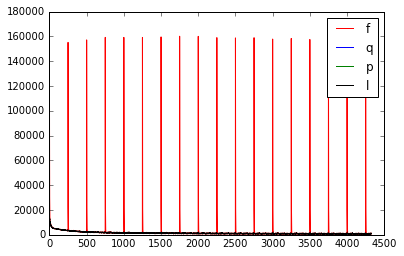

In [8]:
coeff_klrw = 1 / n_batches

plt.plot(fs, 'r')
plt.plot(qs*coeff_klrw, 'b')
plt.plot(ps*coeff_klrw, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')


plt.legend(['f', 'q', 'p', 'l'])
plt.show()

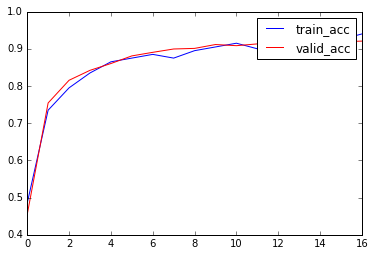

In [9]:
plt.plot(taccs, 'b')
plt.plot(vaccs, 'r')

plt.legend(['train_acc', 'valid_acc'])
plt.show()

# Online version

In [6]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rho = -2, n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False)

layer done
layer done
(10, ?, 10)


In [ ]:
sess.run(tf.initialize_all_variables())

n_epochs = 200
n_batches = len(t_train) / batch_size

fs = list()
qs = list()
ps = list()
ls = list()
taccs = list()
vaccs = list()
for i in range(n_batches):
    
    bnn.reset_lr()
    
    for ep in range(n_epochs):
        
        feed = {bnn.x: x_train[i*batch_size:(i+1)*batch_size], \
                bnn.t: t_train[i*batch_size:(i+1)*batch_size]}
        
        v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
        fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

        if ep > 50 and np.mean(fs[-50:-25]) < np.mean(fs[-25:]):
            last_lr = bnn.get_lr()
            bnn.decay_lr()
            #print("=== learning rate decayed ===")
            if bnn.get_lr == last_lr:
                print("=== cannot decay more. stop learning this batch ===")
                break
            #print ("--- learning rate decayed ---")
            #print bnn.get_lr()

        if ep % 50 == 0:
            train_accuracy = bnn.validate(feed)

            print("batch %d, ep %d, training accuracy %g"%(i, ep, train_accuracy))
            print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        bnn.train(feed)
        
    vacc = bnn.validate({bnn.x: x_valid, bnn.t: t_valid})
    vaccs.append(vacc)
    taccs.append(train_accuracy)
    print("valid accuracy %g"%vacc)
    
#     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
#         bnn.decay_lr()
    
    bnn.update_prior()
    



batch 0, ep 0, training accuracy 0.075
f : 403935.5, q : -331521.4375, p : -710065.3125, l : 20896.6640625
batch 0, ep 50, training accuracy 0.06
f : 332692.90625, q : -333337.46875, p : -657624.0, l : 8144.63378906
batch 0, ep 100, training accuracy 0.145
f : 286573.625, q : -329683.0625, p : -608137.75, l : 6041.01220703
batch 0, ep 150, training accuracy 0.105
f : 251390.15625, q : -321569.15625, p : -567740.8125, l : 5689.74169922
valid accuracy 0.1075
batch 1, ep 0, training accuracy 0.14
f : 227095.953125, q : -313319.4375, p : -535061.125, l : 5410.35644531
batch 1, ep 50, training accuracy 0.165
f : 209846.359375, q : -303758.65625, p : -509538.4375, l : 5385.74365234
batch 1, ep 100, training accuracy 0.19
f : 199473.625, q : -293857.5625, p : -486808.625, l : 5323.47998047
batch 1, ep 150, training accuracy 0.075
f : 190174.71875, q : -285035.25, p : -471502.4375, l : 5441.43066406
valid accuracy 0.1026
batch 2, ep 0, training accuracy 0.105
f : 183828.328125, q : -275661.156

In [ ]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
plt.plot(taccs, 'b')
plt.plot(vaccs, 'r')

plt.legend(['train_acc', 'valid_acc'])
plt.show()

# codes used for testing stuff

In [20]:
a = tf.range(300)
aa = tf.reshape(a, [30, 10])
aaa = tf.tile(tf.expand_dims(aa, 0), [10, 1, 1])

b = tf.truncated_normal([30, 10], stddev = 0.2)

argmaxbs = tf.argmax(b, 1)

In [21]:
b.get_shape()

TensorShape([Dimension(30), Dimension(10)])

In [22]:
sess.run(tf.initialize_all_variables())

In [23]:
tf.reshape(aaa, [-1]).eval()

array([  0,   1,   2, ..., 297, 298, 299], dtype=int32)

In [26]:
ar = tf.range(30).eval()
br = ar * 10 + argmaxbs.eval()
cr = tf.tile(br, [10])

result = tf.gather(tf.reshape(aaa, [-1]), cr).eval()
print result
print result.shape
argmaxbs.eval()



[  5  11  27  32  43  57  63  76  84  97 105 118 123 138 142 158 164 172
 182 193 201 215 227 237 248 258 261 271 281 298   5  11  27  32  43  57
  63  76  84  97 105 118 123 138 142 158 164 172 182 193 201 215 227 237
 248 258 261 271 281 298   5  11  27  32  43  57  63  76  84  97 105 118
 123 138 142 158 164 172 182 193 201 215 227 237 248 258 261 271 281 298
   5  11  27  32  43  57  63  76  84  97 105 118 123 138 142 158 164 172
 182 193 201 215 227 237 248 258 261 271 281 298   5  11  27  32  43  57
  63  76  84  97 105 118 123 138 142 158 164 172 182 193 201 215 227 237
 248 258 261 271 281 298   5  11  27  32  43  57  63  76  84  97 105 118
 123 138 142 158 164 172 182 193 201 215 227 237 248 258 261 271 281 298
   5  11  27  32  43  57  63  76  84  97 105 118 123 138 142 158 164 172
 182 193 201 215 227 237 248 258 261 271 281 298   5  11  27  32  43  57
  63  76  84  97 105 118 123 138 142 158 164 172 182 193 201 215 227 237
 248 258 261 271 281 298   5  11  27  32  43  57  6

array([3, 2, 5, 3, 8, 6, 1, 0, 7, 0, 3, 7, 8, 0, 4, 5, 8, 8, 0, 2, 6, 7, 7,
       0, 3, 7, 8, 3, 8, 0])

In [11]:
tf.shape(a).eval()[0]

2

In [66]:
with sess:
    sess.run(tf.initialize_all_variables())
    print a.eval()
    print tf.tile(a, [6, 3]).eval()
    print tf.tile(tf.expand_dims(a, 0), [2, 1, 1]).eval()
    a = a * b
    print a.eval()
    print tf.tile(a, [6, 3]).eval()
    print tf.transpose(a, [0, 1]).eval()
    print tf.transpose(a, [1, 0]).eval()

[[-0.04836457  0.11699509 -0.10365508]
 [-0.11315618 -0.14960578 -0.13785519]]
[[-0.04836457  0.11699509 -0.10365508 -0.04836457  0.11699509 -0.10365508
  -0.04836457  0.11699509 -0.10365508]
 [-0.11315618 -0.14960578 -0.13785519 -0.11315618 -0.14960578 -0.13785519
  -0.11315618 -0.14960578 -0.13785519]
 [-0.04836457  0.11699509 -0.10365508 -0.04836457  0.11699509 -0.10365508
  -0.04836457  0.11699509 -0.10365508]
 [-0.11315618 -0.14960578 -0.13785519 -0.11315618 -0.14960578 -0.13785519
  -0.11315618 -0.14960578 -0.13785519]
 [-0.04836457  0.11699509 -0.10365508 -0.04836457  0.11699509 -0.10365508
  -0.04836457  0.11699509 -0.10365508]
 [-0.11315618 -0.14960578 -0.13785519 -0.11315618 -0.14960578 -0.13785519
  -0.11315618 -0.14960578 -0.13785519]
 [-0.04836457  0.11699509 -0.10365508 -0.04836457  0.11699509 -0.10365508
  -0.04836457  0.11699509 -0.10365508]
 [-0.11315618 -0.14960578 -0.13785519 -0.11315618 -0.14960578 -0.13785519
  -0.11315618 -0.14960578 -0.13785519]
 [-0.04836457  0.

In [13]:
t1 = np.array([[0.1, 0.2, 0.3, 0.4, 0., 0., 0., 0., 0., 0.], [0.1, 0.2, 0.3, 0.4, 0., 0., 0., 0., 0., 0.]])
t2 = np.array([[0., 0., 1, 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 1, 0., 0., 0., 0., 0., 0.]])
print tf.nn.softmax_cross_entropy_with_logits(t1, t2).eval()
print tf.nn.softmax_cross_entropy_with_logits(t1, t2).eval()


[ 2.11307557  2.01307557]
[ 2.11307557  2.01307557]


In [22]:
tf.log(0.3).eval()

-1.2039728

In [9]:
t3 = tf.tile(tf.expand_dims(np.array([[1], [2], [3], [4], [5]]), 0), [10, 1, 1])
print t3.eval()
t4 = tf.reshape(t3, [-1, 1])
print t4.eval()


[[[1]
  [2]
  [3]
  [4]
  [5]]

 [[1]
  [2]
  [3]
  [4]
  [5]]

 [[1]
  [2]
  [3]
  [4]
  [5]]

 [[1]
  [2]
  [3]
  [4]
  [5]]

 [[1]
  [2]
  [3]
  [4]
  [5]]

 [[1]
  [2]
  [3]
  [4]
  [5]]

 [[1]
  [2]
  [3]
  [4]
  [5]]

 [[1]
  [2]
  [3]
  [4]
  [5]]

 [[1]
  [2]
  [3]
  [4]
  [5]]

 [[1]
  [2]
  [3]
  [4]
  [5]]]
[[1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [12]:
tsh = tf.shape(t3)
tf.shape(t3).eval()
print tsh[-1].eval()

976630367
